# I. Outlier Treatment:

- Handling outliers of all the numerical values 

# II. Feature Engineering:

`add new feature-`

- month number

- weekday number 

- Average shares by daily:

- Average shares by weekend:

- Average shares by data channel:

- title tokens

- text tokens

`analysis -` 
- text/content vs shares
- title vs shares





# III. Feature Extraction:

- Wordcloud of the Title
- Wordcloud of the Text

- POS features:

- Ngram features:

# IV. Saving the final model ready data:

`22DS46`

# 1. Outlier treatment


**1.1 Importing libraries and using them**

In [1]:
import numpy as np
import pandas as pd

import os
import math
import time
import re

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

# Below libraries are for text processing using NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Below libraries are for feature representation using sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Below libraries are for similarity matrices using sklearn
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances

**1.2 Importing the dataset that we performed in EDA part**

In [2]:
df_features = pd.read_csv("data/news_share_data_selected.csv")
df_features.sample(3)

,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,...,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
887,transparency google glass sales,google shut online google glass store wednesda...,Wednesday,0,April,Tech,0,0,0,0,...,3613.040,2585.479,1902.9,0.432288,0.135391,0.043192,0.019034,0.10,0.000000,5200
374,kentucky vs uconn brackets damned final deserve,follow mashableliveopens new window twitter li...,Monday,0,April,Tech,0,0,0,0,...,3571.914,2575.588,1600.5,0.420295,0.204813,0.066667,0.004444,0.75,0.568182,2300
59,grow bushy beard youve always wanted,thinkgeek home things geeky purchase parents c...,Tuesday,0,April,Others,0,0,1,0,...,6003.235,3991.930,5200.0,0.167399,0.073077,0.033149,0.000000,0.40,0.050000,4700


In [3]:
df_features.shape

(999, 28)

In [4]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cleaned_title               999 non-null    object 
 1   cleaned_text                999 non-null    object 
 2   weekday                     999 non-null    object 
 3   is_weekend                  999 non-null    int64  
 4   month                       999 non-null    object 
 5   cleaned_data_channel        999 non-null    object 
 6   Channel_Entertainment       999 non-null    int64  
 7   Channel_Lifestyle           999 non-null    int64  
 8   Channel_Others              999 non-null    int64  
 9   Channel_Social Media        999 non-null    int64  
 10  Channel_Tech                999 non-null    int64  
 11  unique_tokens_rate          999 non-null    float64
 12  num_hrefs                   999 non-null    int64  
 13  num_imgs                    999 non

In [5]:
df_features.columns

Index(['cleaned_title', 'cleaned_text', 'weekday', 'is_weekend', 'month',
       'cleaned_data_channel', 'Channel_Entertainment', 'Channel_Lifestyle',
       'Channel_Others', 'Channel_Social Media', 'Channel_Tech',
       'unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares'],
      dtype='object')

In [6]:
cols_to_treat = ['unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'min_avg_key',
       'max_avg_key', 'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares']

In [7]:
print("\nDistribution (BEFORE outlier treatment):")
display(df_features[cols_to_treat].describe())


Distribution (BEFORE outlier treatment):


,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.527192,11.706707,5.156156,1.219219,4.604425,7.207207,1132.205907,6427.349984,3355.117077,13554.811749,0.446645,0.106056,0.038137,0.017789,0.293408,0.057666,4245.291291
std,0.118711,15.177740,8.452842,4.087347,0.703038,1.859846,1181.656104,7345.282277,1456.857126,51598.155938,0.109343,0.092590,0.015668,0.010574,0.325482,0.267121,22652.511740
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3568.870000,1360.101000,0.000000,0.000000,-0.300000,0.000000,0.000000,0.000000,-1.000000,58.000000
25%,0.466835,4.000000,1.000000,0.000000,4.490862,6.000000,0.000000,3613.040000,2534.726000,1300.000000,0.395563,0.051911,0.028655,0.011224,0.000000,0.000000,1000.000000
50%,0.533149,8.000000,2.000000,0.000000,4.685668,7.000000,984.066700,4635.807000,3004.755000,2766.667000,0.455990,0.102511,0.037325,0.016340,0.200000,0.000000,1600.000000
75%,0.596615,14.000000,7.000000,1.000000,4.856136,9.000000,2116.714500,6561.910000,3809.005000,7341.000000,0.509508,0.162790,0.046892,0.022606,0.500000,0.150000,3100.000000
max,0.867925,162.000000,84.000000,51.000000,7.218430,10.000000,3613.040000,102200.000000,17604.270000,663600.000000,0.875000,0.489623,0.120805,0.103030,1.000000,1.000000,663600.000000


In [8]:
# Outlier treatment using IQR method
def treat_outliers_iqr(df_features, col):
    q1 = df_features[col].quantile(0.25)
    q3 = df_features[col].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    df_features[col] = df_features[col].clip(lower=lower_bound, upper=upper_bound) #clipping every outliers
    return df_features

for col in cols_to_treat:
    df_features = treat_outliers_iqr(df_features, col)

print("\nDistribution (after outlier treatment using IQR method):")
display(df_features[cols_to_treat].describe())



Distribution (after outlier treatment using IQR method):


,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.532183,10.158158,4.260260,0.547548,4.675496,7.207207,1132.205907,5499.373117,3256.800153,4976.071248,0.450364,0.106496,0.037962,0.017433,0.293408,0.056851,2366.762763
std,0.099346,7.654816,5.105337,0.807028,0.284113,1.859846,1181.656104,2231.951378,1047.739362,5258.348719,0.091591,0.087908,0.014989,0.009358,0.325482,0.170974,1812.447026
min,0.272165,0.000000,0.000000,0.000000,3.942951,2.000000,0.000000,3568.870000,1360.101000,0.000000,0.224646,-0.114407,0.001300,0.000000,0.000000,-0.225000,58.000000
25%,0.466835,4.000000,1.000000,0.000000,4.490862,6.000000,0.000000,3613.040000,2534.726000,1300.000000,0.395563,0.051911,0.028655,0.011224,0.000000,0.000000,1000.000000
50%,0.533149,8.000000,2.000000,0.000000,4.685668,7.000000,984.066700,4635.807000,3004.755000,2766.667000,0.455990,0.102511,0.037325,0.016340,0.200000,0.000000,1600.000000
75%,0.596615,14.000000,7.000000,1.000000,4.856136,9.000000,2116.714500,6561.910000,3809.005000,7341.000000,0.509508,0.162790,0.046892,0.022606,0.500000,0.150000,3100.000000
max,0.791285,29.000000,16.000000,2.500000,5.404047,10.000000,3613.040000,10985.215000,5720.423500,16402.500000,0.680424,0.329107,0.074246,0.039680,1.000000,0.375000,6250.000000


In [9]:
print(df_features[cols_to_treat].dtypes)


unique_tokens_rate            float64
num_hrefs                       int64
num_imgs                        int64
num_videos                    float64
average_token_length          float64
num_keywords                    int64
min_avg_key                   float64
max_avg_key                   float64
avg_avg_key                   float64
href_avg_shares               float64
global_subjectivity           float64
global_sentiment_polarity     float64
global_rate_positive_words    float64
global_rate_negative_words    float64
title_subjectivity            float64
title_sentiment_polarity      float64
shares                          int64
dtype: object


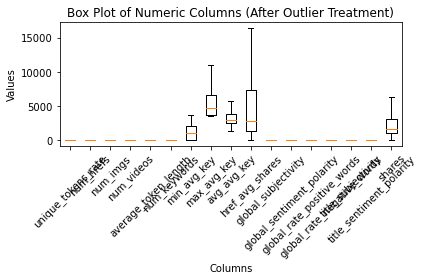

In [10]:
import matplotlib.pyplot as plt

plt.boxplot(df_features[cols_to_treat])

plt.xticks(range(1, len(cols_to_treat) + 1), cols_to_treat, rotation=45)

plt.title('Box Plot of Numeric Columns (After Outlier Treatment)')
plt.xlabel('Columns')
plt.ylabel('Values')

plt.tight_layout()
plt.show()


# 2. Feature Engineering

**2.1 Extracting out the month and day numbers**

In [11]:
from sklearn.preprocessing import LabelEncoder
#encoder = LabelEncoder()
#df_features['month'] = encoder.fit_transform(df_features['month'])
#df_features[''] = encoder.fit_transform(df_features['weekday'])

month_label_mapping = {'March': 3, 'April': 4}
week_label_mapping = {'Friday': 0,'Saturday': 1,'Sunday': 2,'Monday': 3, 'Tuesday': 4, 'Wednesday': 5,'Thursday' : 6}

df_features['month no'] = df_features['month'].map(month_label_mapping)
df_features['weekday no'] = df_features['weekday'].map(week_label_mapping)



**2.2 Categorising all average shares** 

In [12]:
df_features['avg shares daily'] = df_features.groupby('weekday')['shares'].transform('mean')
df_features['avg shares weekly'] = df_features.groupby('is_weekend')['shares'].transform('mean')
df_features['avg shares by channel'] = df_features.groupby('cleaned_data_channel')['shares'].transform('mean')


**2.3 Counting number of tokens for both title and text**

In [13]:
from nltk.tokenize import word_tokenize

def count_tokens(text):
    tokens = word_tokenize(text)
    return len(tokens)

df_features['title_tokens'] = df_features['cleaned_title'].apply(count_tokens)
df_features['text_tokens'] = df_features['cleaned_text'].apply(count_tokens)

df_features[['cleaned_title', 'cleaned_text', 'title_tokens', 'text_tokens']]

,cleaned_title,cleaned_text,title_tokens,text_tokens
0,time youtube competitor,reported last week yahoo getting online video ...,3,102
1,ultimate roundup 2014s biggest april fools day...,april fools marks day pranking goes corporate ...,8,54
2,selfie one garish jacket red sox white house,2013 world series champion boston red sox visi...,8,239
3,african telecom proposes diverse emoticons,less week apple pledged make emoticons raciall...,5,141
4,google launch improved android camera app repo...,android users may soon see series new features...,8,148
...,...,...,...,...
994,make caesar salad 8 super specific apps,lets cut chase apps lot bells whistles theres ...,7,47
995,taylor swift surprised fan bridal shower,taylor swift bridal showers made pastels baked...,6,133
996,amazing spiderman 2 hosts first google hangout...,weve seen big movies throw big google hangouts...,10,84
997,2 animators independently recreated pixar magic,pixar art directors robert kondo dice tsutsumi...,6,445


In [14]:
df_features.sample(4)

,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,...,title_subjectivity,title_sentiment_polarity,shares,month no,weekday no,avg shares daily,avg shares weekly,avg shares by channel,title_tokens,text_tokens
750,cant recognize everyone anymore life fastgrowi...,early employees backbone startups took risk jo...,Monday,0,April,Business,0,0,0,0,...,0.400000,-0.20000,5000,4,3,2441.637795,2316.046429,2312.036810,7,2226
429,top eu court rejects metadata collection law c...,european union top court struck law required t...,Tuesday,0,April,Others,0,0,1,0,...,0.000000,0.00000,1100,4,4,2233.879630,2316.046429,2208.388571,10,386
80,women game developers means success animal cro...,video games exactly question games developers ...,Wednesday,0,April,Others,0,0,1,0,...,0.566667,-0.01667,946,4,5,2157.572687,2316.046429,2208.388571,9,315
924,alleged text passenger doomed south korean fer...,update april 17 1125 et south korean police sa...,Wednesday,0,April,Others,0,0,1,0,...,0.500000,0.00000,1000,4,5,2157.572687,2316.046429,2208.388571,9,338


## 2.4 Analysis of features and business outcome

   ### 2.4.1 Establishing a stacked bar monthly for title_tokens vs shares

<AxesSubplot:xlabel='title_tokens', ylabel='shares'>

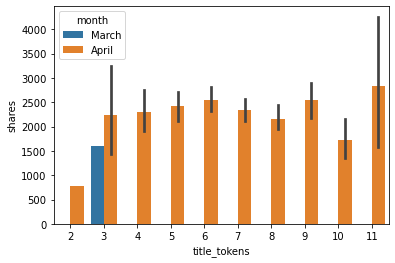

In [15]:
sns.barplot(data=df_features, x="title_tokens", y="shares", hue="month")

**Insights-** 
- The more bigger a title, the more is the number of shares
- The suggestion would be to use title that would contain more than 6 but less than 11 number of words.
- It's seen that although the number of words in title appeared to be 3 but in the month of April it contained a major quantity of popularity, hence shares.

### 2.4.2 Establishing a scatterplot of text_tokens vs shares monthly

<AxesSubplot:xlabel='text_tokens', ylabel='shares'>

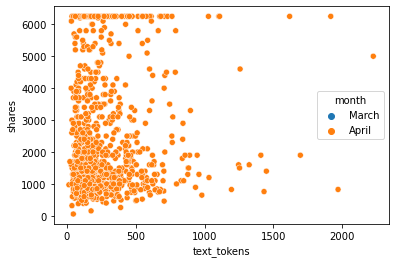

In [16]:
sns.scatterplot(df_features, x= 'text_tokens', y='shares', hue= 'month')

**Insights-** 

- The density of the number of shares tends to be higher when the length of the text tokens falls within the range of 100 to 800 tokens per text. This suggests that articles with text lengths in this range are more likely to receive a significant number of shares. 

# 3. Feature Extraction

## 3.1 Wordcloud of the title 

In [17]:
import re
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
# pip upgrade --Pillow

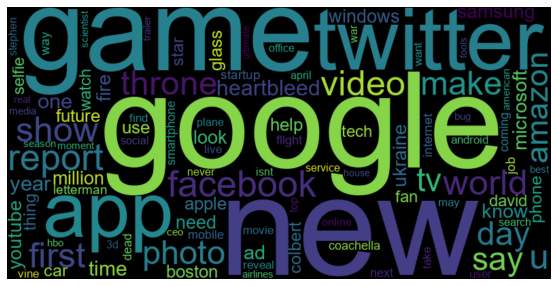

In [19]:
textw = " ".join(sent for sent in df_features['cleaned_title'])
wordcloud = WordCloud(font_path = 'fonts/arial.ttf',width=800, height=400, background_color='black',
 collocations=False, max_words=100).generate(textw)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## 3.2 Wordcloud of the text column

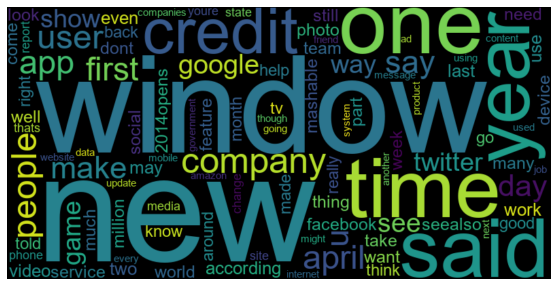

In [20]:
textw = " ".join(sent for sent in df_features['cleaned_text'])
wordcloud = WordCloud(font_path = 'fonts/arial.ttf',width=800, height=400, background_color='black',
 collocations=False, max_words=100).generate(textw)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## 3.3 POS features

In [21]:
import nltk
from nltk import pos_tag

from collections import Counter


1. Defining pos_tags function for counting 

In [22]:
def count_and_classify_pos_tags(text):
    words = word_tokenize(text)  # Tokenizing the text
    pos_tags = pos_tag(words)    # Applying POS tagging
    
    # Counts
    noun_count = 0
    verb_count = 0
    adjective_count = 0
    
    # Iterating through POS tags and classifying them
    for word, tag in pos_tags:
        if tag.startswith('NN'):  
            noun_count += 1
        elif tag.startswith('VB') or tag == 'RB' or tag == 'MD':  # Verbs and adverbs and modals
            verb_count += 1
        elif tag.startswith('JJ'): 
            adjective_count += 1
    
    return {
        'noun_count': noun_count,
        'verb_count': verb_count,
        'adjective_count': adjective_count
    }

2. Applying to the function I created

In [23]:
# Applying the function
df_features['pos_counts_title'] = df_features['cleaned_title'].apply(count_and_classify_pos_tags)
df_features['pos_counts_text'] = df_features['cleaned_text'].apply(count_and_classify_pos_tags)

3. Creating/adding new columns to the features extracted

In [24]:
# Splitting the result into separate columns
df_features[['noun_count_title', 'verb_count_title', 'adjective_count_title']] = df_features['pos_counts_title'].apply(pd.Series)
df_features[['noun_count_text', 'verb_count_text', 'adjective_count_text']] = df_features['pos_counts_text'].apply(pd.Series)


# Dropping the 'pos_counts_title and text' column as it woould not serve purpose in our analysis
df_features.drop('pos_counts_title', axis=1, inplace=True)
df_features.drop('pos_counts_text', axis=1, inplace=True)

In [25]:
df_features.head(3)

,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,...,avg shares weekly,avg shares by channel,title_tokens,text_tokens,noun_count_title,verb_count_title,adjective_count_title,noun_count_text,verb_count_text,adjective_count_text
0,time youtube competitor,reported last week yahoo getting online video ...,Monday,0,March,Business,0,0,0,0,...,2316.046429,2312.03681,3,102,2,0,0,49,28,20
1,ultimate roundup 2014s biggest april fools day...,april fools marks day pranking goes corporate ...,Tuesday,0,April,Tech,0,0,0,0,...,2316.046429,2676.02551,8,54,5,0,2,20,16,12
2,selfie one garish jacket red sox white house,2013 world series champion boston red sox visi...,Tuesday,0,April,Tech,0,0,0,0,...,2316.046429,2676.02551,8,239,3,1,3,103,56,53


## 3.4 Ngrams of title & text

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

def Ngrams_extraction(descriptions):
    # Fill missing values with an empty string
    descriptions = descriptions.fillna('')
    
    vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=7)
    X = vectorizer.fit_transform(descriptions)
    ngram_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    return ngram_df

ngram_title_df = Ngrams_extraction(df_features['cleaned_title'])
ngram_txt_df = Ngrams_extraction(df_features['cleaned_text'])


In [27]:
ngram_title_df.head(5)

,amazon fire,april fools,fire tv,game thrones,google glass,need know,report says
0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1


In [28]:
ngram_txt_df.head(5)

,2014opens new,april 2014opens,fire tv,new window,new york,see also,social media
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,5,5,0,17,0,0,0
3,0,0,0,2,0,1,0
4,0,0,0,1,0,0,0


### 3.4.1 Concatenating them into the original dataframe

In [29]:
# Resetting or else every values would be NaN 
ngram_title_df.reset_index(drop=True, inplace=True)
ngram_txt_df.reset_index(drop=True, inplace=True)

df_features = pd.concat([df_features, ngram_title_df, ngram_txt_df], axis=1)

df_features.sample(3)

,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,...,google glass,need know,report says,2014opens new,april 2014opens,fire tv,new window,new york,see also,social media
196,changing times spur startup growth jerusalem,2000 years since jerusalemopens new window mad...,Thursday,0,April,Business,0,0,0,0,...,0,0,0,0,0,0,19,0,0,0
156,amazon fire tvs 8 stiffest competitors,amazon coming tv near company introduced fire ...,Thursday,0,April,Lifestyle,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
715,puns coming 15 game thrones jokes,brace puns coming comedians diehard game thron...,Sunday,0,April,Entertainment,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## 3.5 Word readability score

In [30]:
#pip install textstat
from textstat import flesch_reading_ease

def calculate_readability(text):
    return flesch_reading_ease(text)

df_features['title_readability'] = df_features['cleaned_title'].apply(calculate_readability)
df_features['text_readability'] = df_features['cleaned_text'].apply(calculate_readability)


checking null in case

In [31]:
df_features.isnull().sum()

cleaned_title                 0
cleaned_text                  0
weekday                       0
is_weekend                    0
month                         0
cleaned_data_channel          0
Channel_Entertainment         0
Channel_Lifestyle             0
Channel_Others                0
Channel_Social Media          0
Channel_Tech                  0
unique_tokens_rate            0
num_hrefs                     0
num_imgs                      0
num_videos                    0
average_token_length          0
num_keywords                  0
min_avg_key                   0
max_avg_key                   0
avg_avg_key                   0
href_avg_shares               0
global_subjectivity           0
global_sentiment_polarity     0
global_rate_positive_words    0
global_rate_negative_words    0
title_subjectivity            0
title_sentiment_polarity      0
shares                        0
month no                      0
weekday no                    0
avg shares daily              0
avg shar

## 3.5 Saving the final model ready data:

In [35]:
#df_features.to_csv("data/news_share_model_ready.csv", index = False)

,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,...,report says,2014opens new,april 2014opens,fire tv,new window,new york,see also,social media,title_readability,text_readability
99,amazons first fire tv ad gets weird gary busey,amazon announced entering living rooms big way...,Wednesday,0,April,Others,0,0,1,0,...,0,0,0,1,0,0,0,0,104.64,15.32
308,windows 8 mistake microsoft seems think,microsoft showed future windows week 2014 buil...,Saturday,1,April,Others,0,0,1,0,...,0,0,0,0,1,0,0,0,56.93,-702.64
597,limbaugh colbert cbs declared war heartland am...,cbs declared war heartland america thats rush ...,Thursday,0,April,Others,0,0,1,0,...,0,3,0,0,8,0,0,0,38.99,-312.21
898,reallife joffrey smiles game thrones purple we...,warning game thrones spoilers ahead looks like...,Wednesday,0,April,Business,0,0,0,0,...,0,0,0,0,1,0,0,0,55.91,-13.79
880,facebook profiles predict work performance,company process hiring new employee theres sta...,Wednesday,0,April,Tech,0,0,0,0,...,0,0,0,0,4,0,0,9,32.56,-353.49
253,google tries trademark glass,king tried trademark candy apple tried tradema...,Friday,1,April,Others,0,0,1,0,...,0,0,0,0,2,0,0,0,92.80,-174.84
62,50yearold identical twins show differently age,take second look photographs identical twins p...,Tuesday,0,April,Entertainment,1,0,0,0,...,0,0,0,0,1,0,0,0,48.47,-28.68
